In [2]:
import pandas as pd
import regex as re
import json
import os
import ast
from datetime import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Avenir'

In [6]:
def read_nb_or_py(path, delete=True):
    """Read a notebook or python file and clean the code.
    """
    # read in the .ipynb file
    try:
        output = "\n"
        with open(path, 'r') as f:
            nb = json.load(f)
        # init a list to store codes of different notebook cells
        out = []
        # iterate over notebook cells to extract the codes
        for cell in nb['cells']:
            if cell['cell_type'] == 'code':
                if type(cell['source']) == list:
                    codes = [i for i in cell['source']
                                if i.startswith('!') is False and i != '\n']
                    codes = [
                        i+"\n" if i.endswith("\n") is False else i for i in codes]
                    out.extend(codes)
                else:
                    out.append(cell['source']+"\n")
        output += "".join(out)
    except:
        if delete:
            os.remove(path)  # delete invalid file to save space
            print(f"{path} is not a valid .ipynb file and has been deleted.")
            return
        print(f"{path} is not a valid .ipynb file")
        return

    # clean up jupyter notebook commands which would cause ast.parse error
    patterns = [re.compile("\n!.+\n"),  # terminal commands
                re.compile("\n%.+\n"),  # magic commands
                re.compile("\n?\s+#.+\n"),  # comments
                re.compile("\n/.+\n")]  # invalid paths
    for p in patterns:
        output = re.sub(p, "\n", output)
    return output


In [7]:
def get_method_name(function_name):
    """Extract method name for from the full function name, e.g. pandas.DataFrame.dropna -> dropna
    """
    keyword = ['.str.', '.plot.', '.dt.', '.cat.', '.sparse.']
    if any([i in function_name for i in keyword]):
        return ".".join(function_name.split('.')[-2:])
    return function_name.split('.')[-1]


def get_all_functions():
    pd_func = pd.read_csv('data/all_functions.csv')
    pd_func['function'] = pd_func['sub_section'].apply(get_method_name)
    return pd_func['function'].tolist()


def get_all_properties():
    pd_func = pd.read_csv('data/all_functions.csv')
    attrs = pd_func[pd_func['is_prop'] ==
                    True]['sub_section'].apply(get_method_name).tolist()
    return list(set(attrs))


PD_FUNCTIONS = get_all_functions()
PD_PROPERTIES = get_all_properties()


In [8]:
def parse_import_lib(code):
    """Parse all imported libraries and corresponding aliases.
    """
    output = []
    for node in ast.iter_child_nodes(ast.parse(code)):
        if isinstance(node, ast.ImportFrom):
            for n in node.names:
                if not n.asname:
                    lib = node.module
                    mod = n.name
                    output.append((f"{lib}.{mod}", mod))
                else:
                    lib = node.module
                    mod = n.name
                    alias = n.asname
                    output.append((f"{lib}.{mod}", alias))
        elif isinstance(node, ast.Import):
            for n in node.names:
                if not n.asname:
                    lib = n.name
                    output.append((lib, lib))
                else:
                    lib = n.name
                    alias = n.asname
                    output.append((lib, alias))
    return list(set(output)) # remove duplicated imports


def check_import_statement(all_libs, library: str):
    """Check whether a library is imported in the code.
    """
    all_libs = [i[0] for i in all_libs]
    if library in all_libs:
        return True
    return False
   
        

In [9]:
def count_func(code, name, functions:list):
    """Count the number of different functions in the code.
    """
    counter = {}
    # find all non-pandas libs and concat into a string delimited by | to form the regex string
    libs = parse_import_lib(code)
    # iterate over different functions to perform regex search
    errors = []
    for f in functions:
        # the regex string matches methods that does not start with any of the non-pandas libs e.g. np.where would not be counted as if df.where
        re_string = form_regex(f, libs)
        try:
            rx = re.compile(re_string)
            # strip white spaces in results
            results = [i.strip() for i in rx.findall(code)]
            count = len(results)
            if count > 0:
                counter[f] = {"count": count, "results": [(name, r) for r in results]}
        except:
            # if regex matching fails, save the error file name
            errors.append(f"{re_string} failed to match for file: {name}\n")
    # write the errors to error_log.txt
    with open(f"error_log_{dt.now().strftime('%d-%m-%Y')}.txt", "a") as f:
        for e in errors:
            f.write(e)
    return counter
            

def form_regex(function:str, libraries):
    """Form the regex pattern for a given function.
    """
    # load exclude prefix rules, where keys are the method/attribute name and values are the prefixes to exclude 
    with open('data/exclude_prefix_rules.json', 'r') as f:
        rules = json.load(f)
    r = rules.get(function)
    non_pd_libs = "|".join([i[1] for i in libraries if i[0].startswith('pandas') is False and i[0] != '*'])
    exclude_prefix = "|".join(
        [r, non_pd_libs]) if r is not None else non_pd_libs
    # form different regex depending on whether the function is a method or a property
    if function in PD_PROPERTIES:
        return f".+(?<!{exclude_prefix})\.{function}[^( \w].*?\n"
    else:
        return f".+(?<!{exclude_prefix})\.{function}\((?:[^)(]+|\((?:[^)(]+|\([^)(]*\))*\))*\)"
    

In [10]:
def gen_source_code(directory="notebooks", limit=2000):
    """Generate source code for all the notebooks in the directory
    """
    all_notebooks = [j for j in os.listdir(directory) if j.endswith('.ipynb')]
    limit = min(limit, len(all_notebooks))
    for file in all_notebooks[:limit]:
        code = read_nb_or_py(os.path.join(directory, file))
        if code is not None:
            yield code, file


def main():
    final_result = {}
    notebook_count = 0 # count number of notebooks analyzed
    all_lib_counter = {} # count number of times each library is imported
    for code, filename in gen_source_code():
        try:
            all_libs = set([l[0].split('.')[0] for l in parse_import_lib(code)]) # only need the library name not the individual modules
            notebook_count += 1
        except:
            # if parsing fails, skip and delete the notebook
            os.remove(os.path.join('notebooks', filename))
            print(f"{filename} is unable to be parsed and has been deleted.")
            continue 
        for l in all_libs:
            if l not in all_lib_counter:
                all_lib_counter[l] = 1
            else:
                all_lib_counter[l] += 1
        if 'pandas' in all_libs:
            # pd_counter['with_pandas'] += 1
            result = count_func(code, filename, PD_FUNCTIONS)
            for i in result:
                if i in final_result:
                    final_result[i]['count'] += result[i]['count']
                    final_result[i]['results'] += result[i]["results"]
                else:
                    final_result[i] = result[i]
        # else: 
        #     pd_counter['without_pandas'] += 1
    
    # form pandas df from the final_result
    df = pd.DataFrame({
        'function': final_result.keys(),
        'count': [i['count'] for i in final_result.values()],
        'codes': [i['results'] for i in final_result.values()],
    })
    df = df.sort_values('count', ascending=False).reset_index(drop=True)
    return df, all_lib_counter, notebook_count
 
df, all_lib_counter, notebook_count= main()
        
        

96674182_bike-ridership-analysis-google-data-analytics.ipynb is unable to be parsed and has been deleted.
96781586_fruit-classification-with-grid-search.ipynb is unable to be parsed and has been deleted.
96705783_trabajo-final-modulo-3-r.ipynb is unable to be parsed and has been deleted.
95873403_statistical-analysis-of-kc-house-sale-data.ipynb is unable to be parsed and has been deleted.
95920410_cyclistr.ipynb is unable to be parsed and has been deleted.
notebooks/96147297_simple-lag-features-and-two-hours.ipynb is not a valid .ipynb file and has been deleted.
notebooks/12501485_starter-1000-cannabis-genomes-project-143a911e-6.ipynb is not a valid .ipynb file and has been deleted.
notebooks/96654941_the-undefeatable-tic-tac-toe-computer-go-first.ipynb is not a valid .ipynb file and has been deleted.
notebooks/91040519_f1-race-traces-2009.ipynb is not a valid .ipynb file and has been deleted.
95959629_churn-detection-with-coarse-classing.ipynb is unable to be parsed and has been delet

In [5]:
df_ = pd.read_csv('pandas_function_count_details.csv')
df = df_.groupby('function').mean().reset_index().sort_values('count', ascending=False)
df

,function,count
95,head,2219.0
191,shape,2191.0
166,read_csv,1656.0
17,append,1493.0
122,loc,1357.0
...,...,...
211,str.isdigit,1.0
210,str.get_dummies,1.0
202,str.cat,1.0
74,dt.weekofyear,1.0


In [12]:
# expand df to inspect the results in detail
df_ = df.explode('codes')
df_['name'] = df_['codes'].apply(lambda x: x[0])
df_['codes'] = df_['codes'].apply(lambda x: x[1])
df_.to_csv('pandas_function_count_details.csv', index=False)
df_


,function,count,codes,name
0,head,2219,sample_sub.head(2),96021625_catboost-timeseries-validation.ipynb
0,head,2219,df_sub.head(2),96021625_catboost-timeseries-validation.ipynb
0,head,2219,train.head(),96085409_stock-nasdaq-price-prediction-flaml-r...
0,head,2219,test.head(),96085409_stock-nasdaq-price-prediction-flaml-r...
0,head,2219,train.head(),96085409_stock-nasdaq-price-prediction-flaml-r...
...,...,...,...,...
261,to_string,1,"wordcloud = WordCloud(max_font_size=50, max_wo...",95886142_mlend-snd-explore-demographics.ipynb
262,pipe,1,".pipe((sns.barplot,'data'),x = ""grade"",y=""Perc...",96622833_lending-loan-logistic-regression.ipynb
263,today,1,end_date = dt.datetime.today(),96787978_stock-price-prediction-on-yahoo-finan...
264,Categorical,1,d['arrival_date_month'] = pd.Categorical(d['ar...,96757621_eda-and-visualizations-on-hotel-booki...


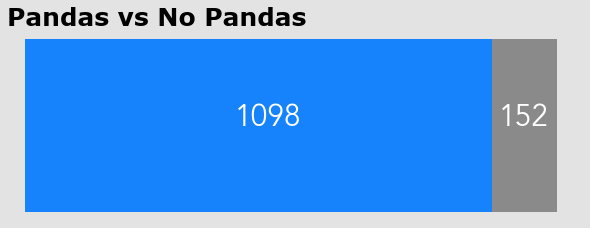

In [6]:
def plot_nb_pd_count(save=True):
    # with_pandas = all_lib_counter['pandas']
    with_pandas = 1098
    # without_pandas = notebook_count - with_pandas
    without_pandas = 152

    # plot
    fig, ax = plt.subplots(figsize=(10, 3.5))
    ax.barh(5, with_pandas,
            color='#0078FF', alpha=0.9, label='With Pandas')
    ax.barh(5, without_pandas, left=with_pandas,
            color='grey', alpha=0.9, label='Without Pandas')
    # ax.set_title("Pandas vs No Pandas",
    #              fontsize=20, fontfamily='Avenir', fontweight='extra bold', loc='left')
    fig.text(0.1, 0.9, f'Pandas vs No Pandas', fontfamily='sans-serif',
             font='Verdana', fontsize=25, fontweight='bold')
    # annotate the chart
    ax.annotate(f"{with_pandas}", xy=(with_pandas, 5), xytext=(with_pandas*0.9/2, 5),
                fontsize=30, fontweight='bold',color='white')
    ax.annotate(f"{without_pandas}", xy=(without_pandas+with_pandas, 5), xytext=(with_pandas+17, 5),
                fontsize=30, fontweight='bold',color='white')

    # removing axis and spines
    ax.axis('off')
    fig.set_facecolor("#e3e3e3")
    if save:
        plt.savefig('chart/notebook_pandas_count.png', dpi=600, bbox_inches="tight")
    plt.show()


plot_nb_pd_count()


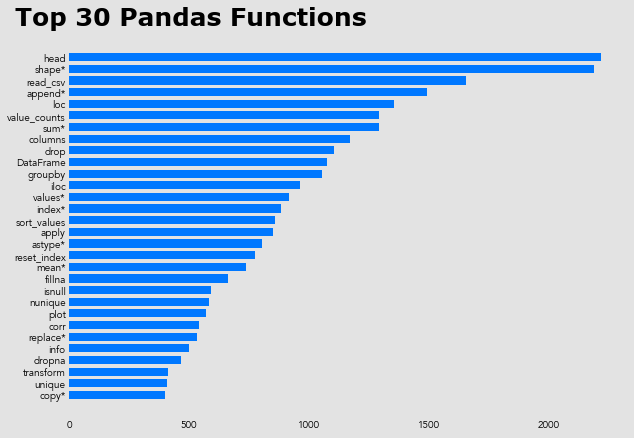

In [7]:
# check builtin methods
builtin_methods = pd.read_csv('data/builtin_methods.csv')['Method'].apply(
    lambda x: x.split('(')[0]).tolist()
np_array_methods = pd.read_csv('data/np_array_methods.csv')['function'].apply(
    lambda x: x.split('.')[-1]).tolist()
# concat the lists
non_pd_methods = builtin_methods + np_array_methods


def plot_pd_func_count(top=30, save=True):
    tmp = df.head(top).sort_values('count')
    fig, ax = plt.subplots(figsize=(10, 7))
    # add asterisk if the method may be miss-counted due to name collision
    y_functions = [i+"*" if i in non_pd_methods else i for i in tmp.function]
    ax.barh(y=y_functions,
            width=tmp['count'].tolist(), color='#0078FF', height=0.7)
    fig.text(0.05, 0.9, f'Top {top} Pandas Functions', fontfamily='sans-serif',
             font='Verdana', fontsize=25, fontweight='bold')
    # remove spines
    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_visible(False)
        
    # remove x & y ticks
    ax.tick_params(axis='both', which='both', length=0)
    
    # set color
    fig.set_facecolor("#e3e3e3")
    ax.set_facecolor("#e3e3e3")
    if save:
        plt.savefig(f'chart/top_{top}_functions.png',
                    dpi=600, bbox_inches="tight")
    plt.show()


plot_pd_func_count()


In [111]:
top_30 = df_.groupby('function').agg({'count': 'mean'}).sort_values(
    'count', ascending=False).reset_index()['function'].head(30).to_list()
tmp = df_[df_['function'].isin(top_30)].groupby(
    ['name', 'function']).count().reset_index()
tmp


,name,function,count,codes
0,10034990_starter-pokemon-images-dataset-75f0a7...,columns,2,2
1,10034990_starter-pokemon-images-dataset-75f0a7...,corr,2,2
2,10034990_starter-pokemon-images-dataset-75f0a7...,dropna,2,2
3,10034990_starter-pokemon-images-dataset-75f0a7...,iloc,2,2
4,10034990_starter-pokemon-images-dataset-75f0a7...,nunique,3,3
...,...,...,...,...
9696,96884099_shlee-0-7889.ipynb,mean,1,1
9697,96884099_shlee-0-7889.ipynb,nunique,1,1
9698,96884099_shlee-0-7889.ipynb,read_csv,4,4
9699,96884099_shlee-0-7889.ipynb,sort_values,6,6


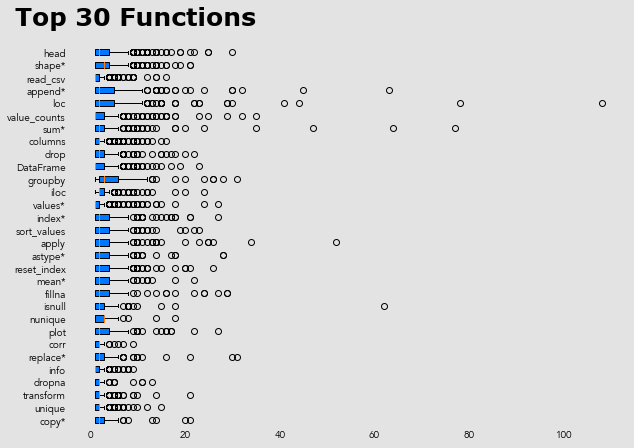

In [109]:
def top_func_boxplot(top=30, save=True):
    data = {}
    for f in reversed(top_30):
        asterisk = "*" if f in non_pd_methods else ''
        data[f+asterisk] = tmp[tmp['function'] == f]['count'].values

    fig, ax = plt.subplots(figsize=(10, 7))
    bplot = ax.boxplot(data.values(), vert=False,patch_artist=True)
    ax.set_yticklabels(data.keys())
    fig.text(0.05, 0.92, 'Top 30 Functions', fontfamily='sans-serif',
             font='Verdana', fontsize=25, fontweight='bold')

    for patch in bplot['boxes']:
        patch.set_facecolor("#0078FF")

    # remove spines
    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_visible(False)
        
    # remove x & y ticks
    ax.tick_params(axis='both', which='both', length=0)

    # set color
    fig.set_facecolor("#e3e3e3")
    ax.set_facecolor("#e3e3e3")
    if save:
        plt.savefig(f'chart/top_{top}_functions_boxplot.png',
                    dpi=600, bbox_inches="tight")

    plt.show()


top_func_boxplot()


In [18]:
lib_count = pd.DataFrame(all_lib_counter, index=['count']).T.reset_index()
lib_count.columns = ['module', 'count']
lib_count = lib_count.sort_values('count', ascending=False)
lib_count.head(10)

,module,count
5,pandas,1098
6,numpy,1050
1,matplotlib,893
2,os,739
0,sklearn,737
12,seaborn,523
8,warnings,210
21,tensorflow,177
36,mpl_toolkits,141
9,tqdm,121


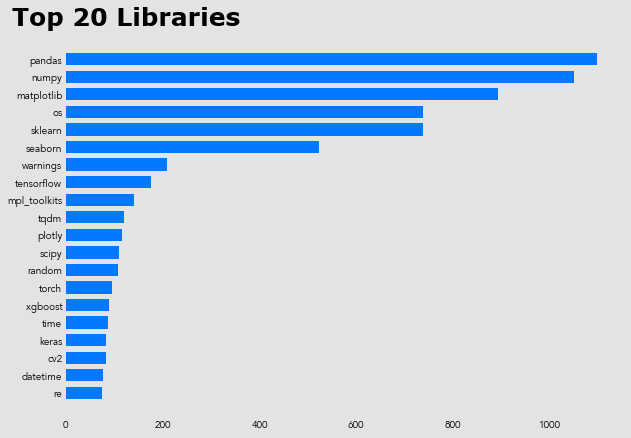

In [122]:
def plot_top_libraries(top=20, save=True):
    tmp = lib_count.head(top).sort_values('count')
    fig, ax = plt.subplots(figsize=(10, 7))

    ax.barh(y=tmp['module'],
            width=tmp['count'].tolist(), color='#0078FF', height=0.7)
    fig.text(0.05,0.9,f'Top {top} Libraries',fontfamily='sans-serif', font='Verdana', fontsize=25,fontweight='bold')
   
    # remove spines
    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_visible(False)
        
    # remove x & y ticks
    ax.tick_params(axis='both', which='both', length=0)
    
    # set color
    fig.set_facecolor("#e3e3e3")
    ax.set_facecolor("#e3e3e3")
    if save:
        plt.savefig(f'chart/top_{top}_libraries.png',
                    dpi=600, bbox_inches="tight")
    plt.show()
    
plot_top_libraries(top=20)